<a href="https://colab.research.google.com/github/marabian/face-mask-detection/blob/master/face_mask_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
- [0. Objective](#objective)
- [1. Data processing](#data_process)
- [2. Build and train CNN](#build_and_train_cnn)
- [3. Predict using model](#predict_cnn)

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import itertools
import os
import shutil
import random
from random import randint
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
# check if tensorflow is identifying gpu, uncomment if using gpu
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#print("Num GPUs Available: " , len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
print(os.getcwd())

/content


In [ ]:
# test

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
print(os.getcwd())

/content


In [22]:
%cd "/content/drive/My Drive/projects/face-mask-detection"

/content/drive/My Drive/projects/face-mask-detection


In [23]:
!ls

data			       models		   README.md	     split.py
face_mask_detection_cnn.ipynb  old_notebook.ipynb  requirements.txt


<a id='objective'></a> 
# 0. Objective
Build and train a **Convolutional Neural Network** using Tensorflow's Keras API that can classify images of people by detecting face masks. The goal is to train a NN model that can take an image of a person, and identify if they are wearing a face-mask.

The model should classify images as either "mask" or "no-mask".

<a id='data_process'></a> 
# 1. Data Processing
First thing we need to do is to get and prepare out data set for which we will be training our model.
The data set we’ll use is from the Kaggle [Face Mask Detection Dataset](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset)

Download the dataset from Kaggle [here](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset). Our raw dataset contains 6,024 total images (in .png .jpg .jpeg formats) found under directory *data/medical_masks/images*. The first 1800 images are not labeled, and should be used for the **test set**. The remaining 4,224 can be used for **training** and **validation sets**. <br>
Lets take a look at the .csv file provided...

## Load csv data

In [24]:
# Let's see what our data looks like
df = pd.read_csv('data/train.csv')

In the dataframe below, each sample has a: 

- **name** - these are the names of the images in our dataset.
- **x1, x2, y1, y2** - [bounding box](https://medium.com/anolytics/the-use-of-bounding-boxes-in-image-annotation-for-object-detection-6371711eabba) coordinates
- **classname** - one of 20 possible classes: hijab_niqab, mask_colorful, mask_surgical, face_no_mask, face_with_mask_incorrect, face_with_mask, face_other_covering, scarf_bandana, balaclava_ski_mask, face_shield, other, gas_mask, turban, helmet, sunglasses, eyeglasses, hair_net, hat, goggles, hood. We will only consider the classes **face_with_mask** and **face_no_mask**.

We will use this data to construct new images using the script `split.py`

In [25]:
# Check out a few rows of the dataframe
print(df.shape)
df.head()

(15412, 6)


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


## Data processing using `split.py`

### Run script `split.py` to generate images and place them in train, valid, test directories

Run the script found in the project directory called `split.py`. This script takes 5 arguments: The path to raw image data, the path to *train.csv*, % for training set, % for validation set, % for test. This script uses the image names, bounding box data, and classnames provided in the dataset to construct new images. These images are placed in **train/**, **valid/**, and **test**/ directories. The percentages specify the ratio of the split for each dataset.

## Image processing using Keras

In [ ]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

### Put images into [Keras Data Generator](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) format
[More on Data Generators](https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c)
This will basically create batches of data from the directories where our datasets reside. These batches of data will be able to be passed to the Sequential model using the **fit** function.

In [ ]:
# Let's preprocess the images using Keras
train_batches = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10)

valid_batches = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10)

# shuffle=False because when we use our batches for inference, we want to look at the results in a confusion matrix
# so we need to access the unshuffled labels for our test set. 
test_batches = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10, shuffle=False)

Found 4600 images belonging to 2 classes.
Found 862 images belonging to 2 classes.
Found 287 images belonging to 2 classes.


In [ ]:
assert train_batches.n == 4600 
assert valid_batches.n == 862 
assert test_batches.n == 287 
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes

### Grab a single batch of images and corresponding labels from our training batches
Since our batch size is 10, this should be 10 images along with 10 corresponing labels. Lets print some of these images using this function pulled directly from [Tensorflow's website](https://www.tensorflow.org/tutorials/images/classification#visualize_training_images).

In [45]:
imgs, labels = next(train_batches)

NameError: ignored

In [48]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [47]:
plotImages(imgs)
print(labels)

NameError: ignored

As seen above, the labels are [one-hot encoded](https://deeplizard.com/learn/video/v_4KWmkwmsU) vectors representing either 'mask' or 'no-mask'. A [1, 0] represents **mask**, and a [0, 1] represents **no-mask**.

<a id='build_and_train_cnn'></a>
# 2. Build and Train a Convolutional Neural Network

## Lets create our CNN model! - first try

In [38]:
# first try
model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=256, activation='relu'), # was 128
    Dropout(0.5), # was 0.4
    Dense(units=2, activation='softmax')
])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)           

In [40]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_m1 = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=50, # was best at 9
    verbose=2
)

Epoch 1/50
460/460 - 193s - loss: 0.3461 - accuracy: 0.8502 - val_loss: 0.2383 - val_accuracy: 0.9084
Epoch 2/50
460/460 - 193s - loss: 0.2622 - accuracy: 0.8867 - val_loss: 0.2207 - val_accuracy: 0.9026
Epoch 3/50
460/460 - 192s - loss: 0.2469 - accuracy: 0.8941 - val_loss: 0.1912 - val_accuracy: 0.9316
Epoch 4/50
460/460 - 192s - loss: 0.2254 - accuracy: 0.9093 - val_loss: 0.1921 - val_accuracy: 0.9258
Epoch 5/50
460/460 - 193s - loss: 0.2188 - accuracy: 0.9157 - val_loss: 0.2182 - val_accuracy: 0.9165
Epoch 6/50
460/460 - 192s - loss: 0.2209 - accuracy: 0.9111 - val_loss: 0.1953 - val_accuracy: 0.9281
Epoch 7/50
460/460 - 193s - loss: 0.2047 - accuracy: 0.9215 - val_loss: 0.1920 - val_accuracy: 0.9316
Epoch 8/50
460/460 - 192s - loss: 0.2009 - accuracy: 0.9213 - val_loss: 0.1973 - val_accuracy: 0.9188
Epoch 9/50
460/460 - 192s - loss: 0.1970 - accuracy: 0.9235 - val_loss: 0.1723 - val_accuracy: 0.9385
Epoch 10/50
460/460 - 193s - loss: 0.1867 - accuracy: 0.9265 - val_loss: 0.1750 - 

In [ ]:
model.save_weights('models/first_try.h5')  # always save your weights after training or during training

In [ ]:
# plot training metrics - learning curves
def plot_training_history(history):
    fig = plt.figure()
    ax = fig.add_
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

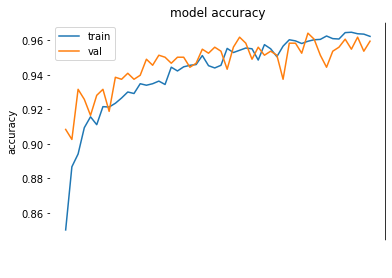

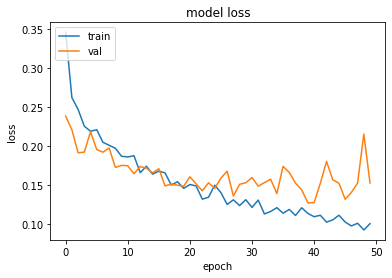

In [ ]:
plot_training_histor(history_m1)

Looking at the loss curve, we can see that the validation accuracy is optimal around epoch 40 and goes up after. We should stop training at that point.

## Let's try fine tuning vgg16 - second try

The only preprocessing applied to the images is the same preprocessing step used by the popular [vgg16](https://neurohive.io/en/popular-networks/vgg16/) image classifier CNN model.

In [26]:
# Let's preprocess the images in the same way vgg16 does
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, horizontal_flip=True) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10, shuffle=False)

NameError: ignored

In [27]:
# The original trained VGG16 model, along with its saved weights and other parameters
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 4s 0us/step


In [28]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
# replicate to Sequential model and remove output layer
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [30]:
# freeze weights in all layers
for layer in model.layers:
    layer.trainable = False

In [31]:
# add new output layer
model.add(Dense(units=2, activation='softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [33]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
hist_m2 = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

NameError: ignored

In [ ]:
model.save_weights('models/second_try.h5')  # always save your weights after training or during training

In [ ]:
plot_training_histor(hist_m2) # plot learning curve

<a id='predict_cnn'></a>
# 3. Predictions

Let's predict using our first model

In [41]:
model.load_weights('models/first_try.h5')

In [42]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

NameError: ignored

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=2)

29/29 - 2s


In [ ]:
predictions = np.round(predictions)

array([1., 0.], dtype=float32)

### Plot Predictions With A Confusion Matrix function using [scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[206   3]
 [  7  71]]


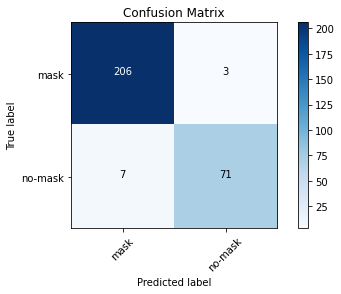

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['mask','no-mask']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

We can see that the model incorrectly predicted only 10 samples out of 277. This gives us 96% accuracy on the test set, not bad!

In [43]:
me_batches = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory='data/me', target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10, shuffle=False)

Found 3 images belonging to 2 classes.


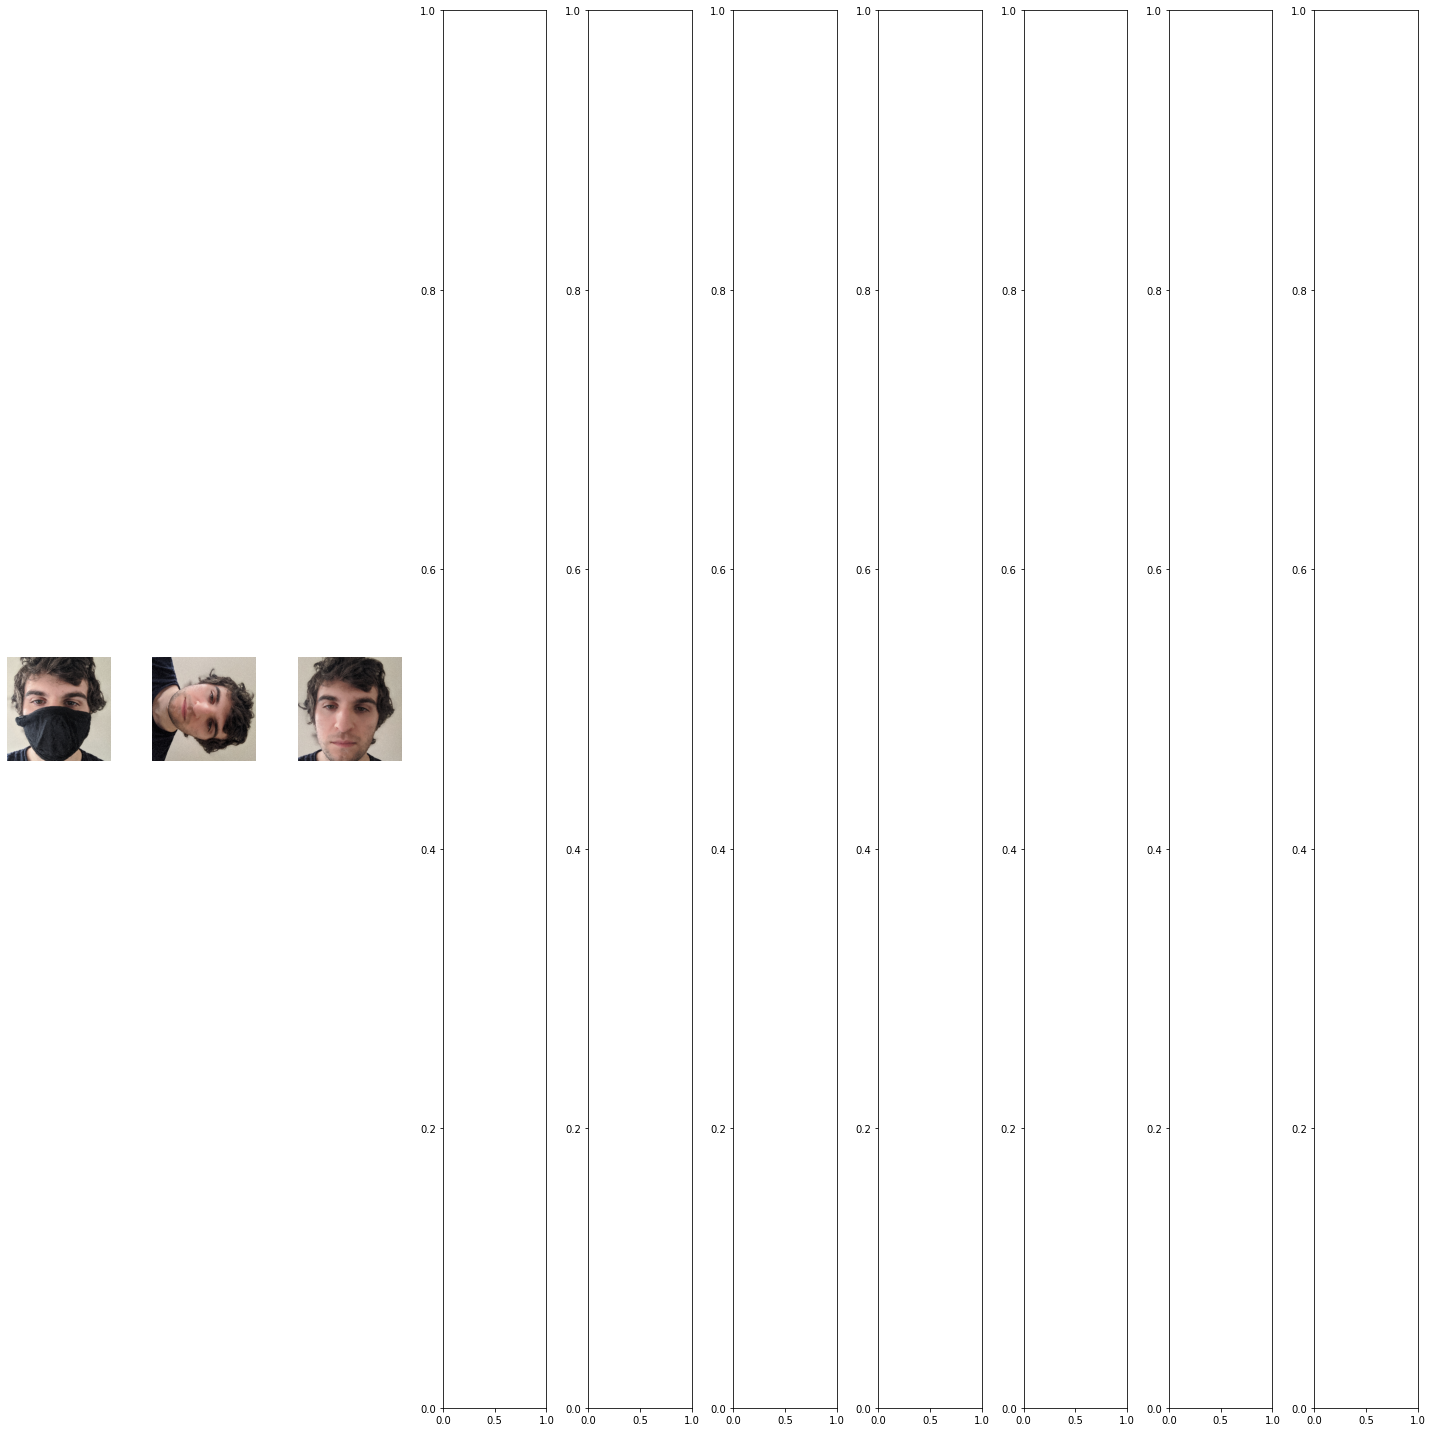

[[1. 0.]
 [0. 1.]
 [0. 1.]]


In [49]:
me_imgs, me_labels = next(me_batches)
plotImages(me_imgs)
print(me_labels)

In [50]:
predictions_me = model.predict(x=me_batches, steps=len(me_batches), verbose=2)

1/1 - 0s


In [51]:
predictions_me

array([[0.9989907 , 0.00100928],
       [0.16632251, 0.8336775 ],
       [0.09037535, 0.9096247 ]], dtype=float32)